## importing needed libraries 

In [1]:
import os
from tqdm import tqdm
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score,roc_curve, auc,silhouette_score
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
from skimage import io

# feature extraction function 

In [2]:
def extract_hog_features(image_path):
    # Open the image and convert to grayscale
    img = Image.open(image_path).convert('L')

    pixels_per_cell = (8, 8)  # Adjust as needed
    cells_per_block = (2, 2)

    # Resize the image 
    resize_shape = (256, 256)
    img_resized = resize(np.array(img), resize_shape, anti_aliasing=True)

    features = hog(img_resized, orientations=9, pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block, transform_sqrt=True, feature_vector=True)
    return features

# load function

In [3]:

  def load_images_and_labels( data_dir, num_images_per_class):
        image_paths = []
        labels = []

        # List subdirectories (assuming each subdirectory is a separate class)
        classes = sorted(os.listdir(data_dir))

        for i, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)

            # Check if the class has enough images
            num_images_in_class = len(os.listdir(class_path))
            if num_images_in_class < num_images_per_class:
                print(f"Skipping class '{class_name}' because it doesn't have enough images.")
                continue

            # Counter to track the number of images loaded for the current class
            images_loaded = 0

            # Iterate through images in the current class
            for img_name in os.listdir(class_path):
                if images_loaded >= num_images_per_class:
                    break  # Stop loading more images for the current class

                img_path = os.path.join(class_path, img_name)

                # Append the image path and its label to the lists
                image_paths.append(img_path)
                labels.append(class_name)

                images_loaded += 1

        return image_paths, labels

# data visualization fuction

In [4]:
def count_images_per_class(dataset_path):
    class_counts = {}
    
    for root, dirs, files in os.walk(dataset_path):
        for dir_name in dirs:
            class_path = os.path.join(root, dir_name)
            class_count = len(os.listdir(class_path))
            class_counts[dir_name] = class_count
    
    return class_counts

def plot_image_counts(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# visalization

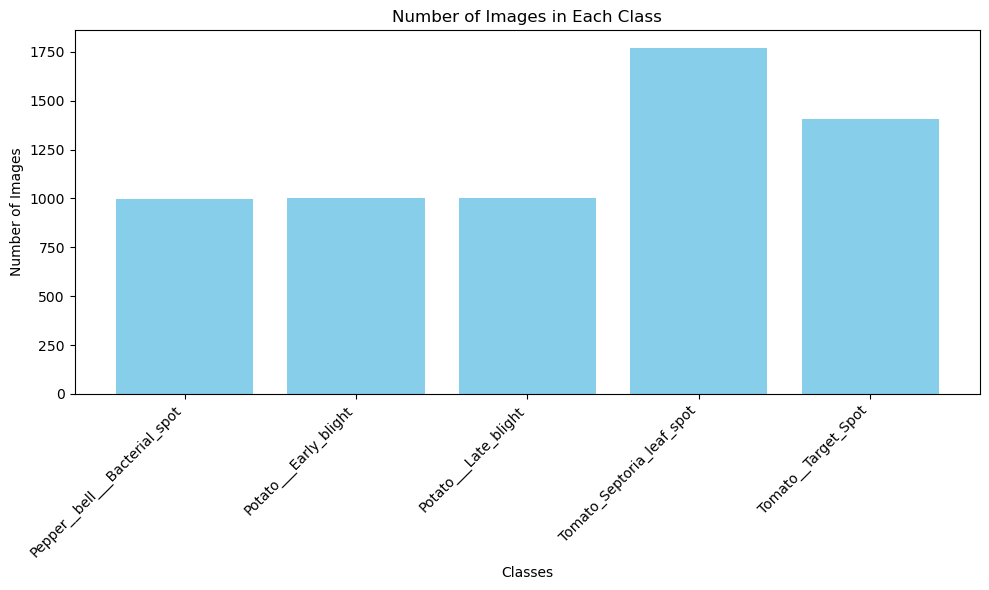

In [5]:
data_dir = 'C:\\Users\\user\\Desktop\\ml_project\\dataset'
class_counts = count_images_per_class(data_dir)
plot_image_counts(class_counts)



# load ,preprocessing and feature extraction

In [6]:
num_images_loaded_per_class= 700
images, labels =load_images_and_labels(data_dir, num_images_loaded_per_class)
print(len(images))
all_hog_features = []


3500


In [7]:
for img_path in tqdm(images):
    hog_features = extract_hog_features(img_path)

    # Append features and labels to lists
    all_hog_features.append(hog_features)
    features_array = np.array(all_hog_features)
labels_array = np.array(labels)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

100%|██████████| 3500/3500 [11:12<00:00,  5.20it/s]


# Split the data

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.2, random_state=42)



# fitting model

In [9]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Evaluateion

Accuracy: 0.7628571428571429


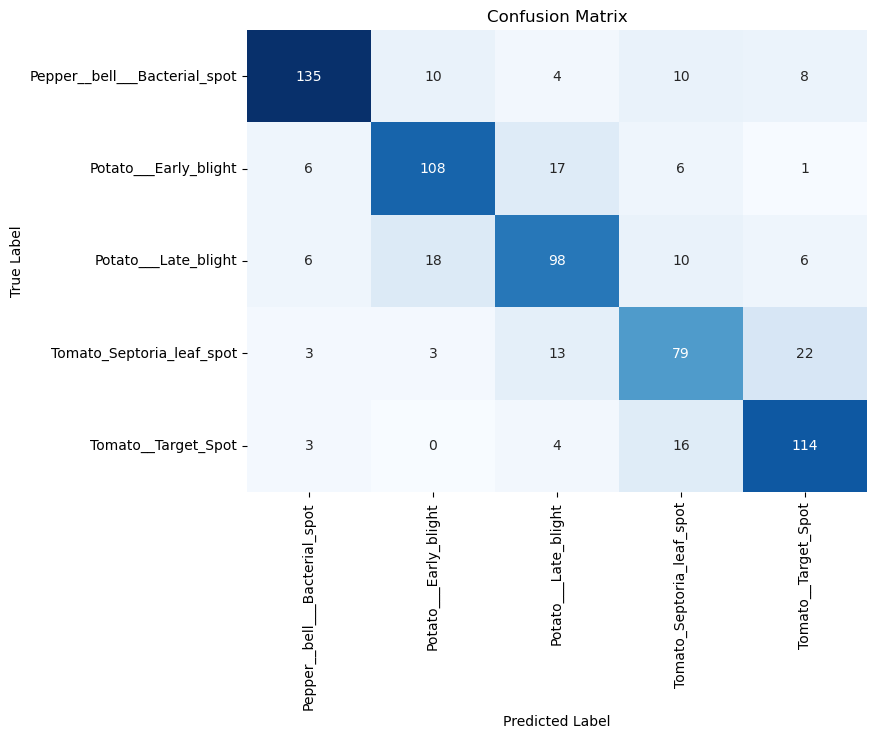

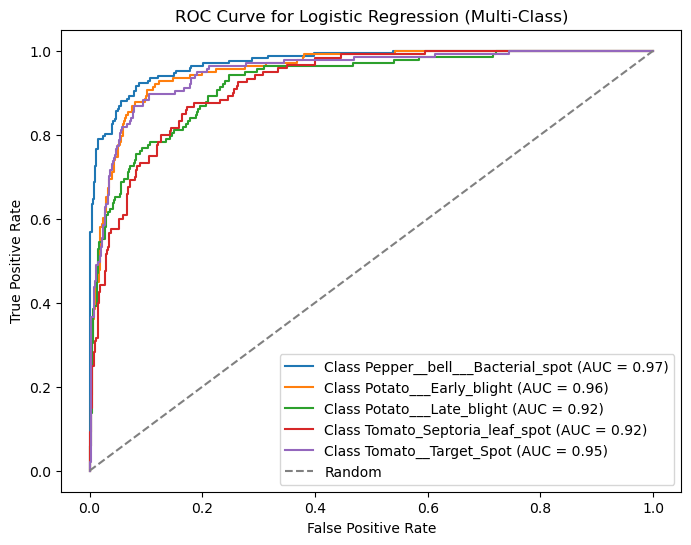

In [10]:
# Make predictions on the test set
y_pred = logreg.predict(X_test)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC curve
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), logreg.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (Multi-Class)')
plt.legend()
plt.show()

# kmeans

# build model

In [11]:
# Specify the number of clusters (classes)
num_clusters = len(set(labels))  # Number of unique classes in your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the k-means model on the training data
kmeans.fit(X_train)


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [12]:
unique_labels = list(set(labels))

# Create a mapping between cluster labels and unique class names
cluster_class_mapping = {'cluster': list(range(num_clusters)), 'class_name': unique_labels[:num_clusters]}

# Create a DataFrame from the mapping
class_mapping_df = pd.DataFrame(cluster_class_mapping)

# Print or display the resulting DataFrame
print(class_mapping_df)

   cluster                     class_name
0        0          Potato___Early_blight
1        1      Tomato_Septoria_leaf_spot
2        2            Tomato__Target_Spot
3        3           Potato___Late_blight
4        4  Pepper__bell___Bacterial_spot


# mapping fucation

In [13]:


def map_cluster_to_class(cluster_result, class_mapping_df):
    
    # Create a mapping dictionary from the DataFrame
    mapping_dict = dict(zip(class_mapping_df['cluster'], class_mapping_df['class_name']))

    # Map cluster labels to class names
    class_names = [mapping_dict[cluster_label] for cluster_label in cluster_result]

    return class_names

# test mabbing

In [14]:
# Predict cluster labels 
new_data_point = X_train  # Replace 0 with the index of the data point
predicted_cluster = kmeans.predict(new_data_point)

# Map the predicted cluster to class name using the function
predicted_class_names = map_cluster_to_class(predicted_cluster, class_mapping_df)

# Display the result
print(f"Predicted Class Name: {predicted_class_names}")

Predicted Class Name: ['Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Potato___Early_blight', 'Tomato_Septoria_leaf_spot', 'Potato___Late_blight', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Tomato_Septoria_leaf_spot', 'Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Potato___Late_blight', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Potato___Late_blight', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Tomato__Target_Spot',

In [15]:
cluster_labels_test=kmeans.predict(X_test)
test_accuracy = accuracy_score(y_test, cluster_labels_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.32
